In [ ]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades/'
PATH_NN= BASE+'NN_data_1_4/'
save_path=BASE+"trained_models"


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset

# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch



submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'],res='1_12')


train_loader=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=64,
    sampler=SubsetRandomSampler(submeso_dataset.train_ind))

test_loader=DataLoader(
    submeso_dataset,
    num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)

In [154]:
model = torch.load('/scratch/ab10313/pleiades_new/trained_models/fcnn_k5_l3_res_1_4_tmp.pt')


In [155]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [156]:
WB_mean = np.load(PATH_NN+'WB_sg_mean.npy')
WB_std = np.load(PATH_NN+'WB_sg_std.npy')
mean_tile = np.tile(WB_mean,(2030,40,40))
std_tile = np.tile(WB_std,(2030,40,40))

for x_data, y_data in test_loader:
    prediction = np.squeeze(model(x_data.to(device)).detach().numpy())*std_tile + mean_tile 
    target = np.squeeze(y_data.detach().numpy())*std_tile + mean_tile

baseline_mse =  np.mean((target.flatten() - target.mean()) ** 2)

In [157]:
r2_cnn_timeseries = np.zeros(2030)
for it in range(2030):
    r2_cnn_timeseries[it] = 1 - mean_squared_error(prediction[it,:,:].flatten(),target[it,:,:].flatten())/baseline_mse

In [10]:
label_list = ['Arabian Sea','New Zealand', 'Agulhas Current', 'Kuroshio Extension', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific','California Current', 'Indian Ocean', ]

In [160]:

#locations
location_index = np.zeros(846*12)
location_month_index= np.zeros(846*12)


for i in range(12):
    for j in range(846):
        location_index[i*846+j] = i
        location_month_index[i*846+j] = np.floor(j/60)


# prediction timeseries

In [161]:

test_ind = submeso_dataset.test_ind

r2_cnn_timeseries_loc = np.empty((12,2030))
r2_cnn_timeseries_loc[:] = np.nan

location_month_index_test = location_month_index[test_ind]
location_month_index_loc = np.empty((12,2030))
location_month_index_loc[:] = np.nan

for i_loc in range(12):    
    r2_cnn_timeseries_loc[i_loc,location_index[test_ind]==i_loc] = r2_cnn_timeseries[location_index[test_ind]==i_loc]
    location_month_index_loc[i_loc,location_index[test_ind]==i_loc] = location_month_index_test[location_index[test_ind]==i_loc]



In [8]:
lat_rad = np.empty(12)
PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')
i_lat_path = 0


for i_lat in range(12):
    #if i_lat == 1 or i_lat ==10 or i_lat ==11:
    #    lat_rad[i_lat] = np.NaN
    #else:
    #    print(i_lat_path)
        lat_rad[i_lat] = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()
    #    i_lat_path = i_lat_path+1
    
    
lat_rad_sorted = np.sort(lat_rad)[::-1]
lat_ind_sorted = np.argsort(lat_rad)[::-1]

In [163]:
r2_cnn_timeseries_loc_time_mean = np.empty((12,12))
for i_loc in range(12):
    for i_month in range(12):
        r2_cnn_timeseries_loc_time_mean[i_loc,i_month] = np.mean(r2_cnn_timeseries_loc[i_loc,~np.isnan(r2_cnn_timeseries_loc[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        

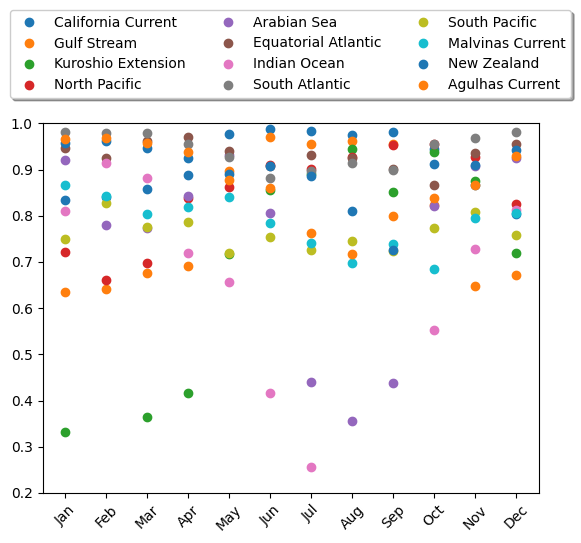

In [165]:
for ii in range(12):
    i_loc = lat_ind_sorted[ii]
    plt.plot(np.roll(r2_cnn_timeseries_loc_time_mean[i_loc,:],-3),'o',label=label_list[i_loc])
    

plt.ylim([0.2,1])
my_xticks = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep', 'Oct','Nov','Dec',]
plt.xticks(np.arange(0,12,1), my_xticks,rotation = 45); 
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

In [2]:
#!/usr/bin/env python
# coding: utf-8

import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades/'
PATH_NN= BASE+'NN_data_smooth/'
save_path=BASE+"trained_models"


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset


# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

    
    
    
res_strg = ['1_12','1_8','1_4','1_2','1']

#r2_cnn_loc = np.empty((5,12))
#r2_cnn_loc[:] = np.nan
#r2_param_loc = np.empty((5,12))
#r2_param_loc[:] = np.nan


r2_cnn_monthly_mean = np.empty((5,12,12))
r2_cnn_monthly_mean[:] = np.nan
r2_param_monthly_mean = np.empty((5,12,12))
r2_param_monthly_mean[:] = np.nan

for i_res in range(1):
    i_res = 4
    submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR',  'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'], res=res_strg[i_res])


    test_loader=DataLoader(
        submeso_dataset,
        num_workers=10,
        batch_size=len(submeso_dataset.test_ind),
        sampler=submeso_dataset.test_ind)

    
    # load trained models
    model= torch.load('/scratch/ab10313/pleiades/trained_models/fcnn_k5_l3_res_'+res_strg[i_res]+'_tmp.pt')
    
    WB_FK08_param = 0.07*np.load(BASE+'NN_data_'+res_strg[i_res]+'/WB_FK08_param.npy')[submeso_dataset.test_ind] 

    for x_data, y_data in test_loader:
        prediction = model(x_data.to(device)).detach().numpy() 
        target = y_data.detach().numpy()
                              
    baseline_mse =  np.mean((target.flatten() - target.mean()) ** 2)                       
                              

    r2_cnn_timeseries = np.zeros(2030)
    r2_param_timeseries = np.zeros(2030)
    
    for it in range(2030):
        r2_cnn_timeseries[it] = 1 - mean_squared_error(prediction[it,:,:].flatten(),target[it,:,:].flatten())/baseline_mse
        r2_param_timeseries[it] = 1 - mean_squared_error(WB_FK08_param[it,:,:].flatten(),target[it,:,:].flatten())/baseline_mse

    
    #locations
    location_index = np.zeros(846*12)
    location_month_index= np.zeros(846*12)
    
    
    for i in range(12):
        for j in range(846):
            location_index[i*846+j] = i
            location_month_index[i*846+j] = np.floor(j/60)

 
    test_ind = submeso_dataset.test_ind
    
    r2_cnn_timeseries_loc = np.empty((12,2030))
    r2_cnn_timeseries_loc[:] = np.nan
    r2_param_timeseries_loc = np.empty((12,2030))
    r2_param_timeseries_loc[:] = np.nan
    
    location_month_index_test = location_month_index[test_ind]
    location_month_index_loc = np.empty((12,2030))
    location_month_index_loc[:] = np.nan
    
    for i_loc in range(12):    
        r2_cnn_timeseries_loc[i_loc,location_index[test_ind]==i_loc] = r2_cnn_timeseries[location_index[test_ind]==i_loc]
        r2_param_timeseries_loc[i_loc,location_index[test_ind]==i_loc] = r2_param_timeseries[location_index[test_ind]==i_loc]
        location_month_index_loc[i_loc,location_index[test_ind]==i_loc] = location_month_index_test[location_index[test_ind]==i_loc]
    


    r2_cnn_timeseries_loc_time_mean = np.empty((12,12))
    r2_param_timeseries_loc_time_mean = np.empty((12,12))
    
    for i_loc in range(12):
        for i_month in range(12):
            r2_cnn_timeseries_loc_time_mean[i_loc,i_month] = np.mean(r2_cnn_timeseries_loc[i_loc,~np.isnan(r2_cnn_timeseries_loc[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
            
            r2_param_timeseries_loc_time_mean[i_loc,i_month] = np.mean(r2_param_timeseries_loc[i_loc,~np.isnan(r2_param_timeseries_loc[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])


    r2_cnn_monthly_mean[i_res,:,:] = r2_cnn_timeseries_loc_time_mean[:,:]
    r2_param_monthly_mean[i_res,:,:] = r2_param_timeseries_loc_time_mean[:,:]
        

#np.save('/scratch/ab10313/pleiades/trained_models/r2_cnn_monthly_mean.npy',r2_cnn_monthly_mean)
#np.save('/scratch/ab10313/pleiades/trained_models/r2_param_monthly_mean.npy',r2_param_monthly_mean)

#np.save('/scratch/ab10313/pleiades/trained_models/r2_param_summer_loc.npy',r2_param_summer_loc)
#np.save('/scratch/ab10313/pleiades/trained_models/r2_param_winter_loc.npy',r2_param_winter_loc)


CUDA Not Available


/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
r2_cnn_monthly_mean[4,:,:].shape

(12, 12)

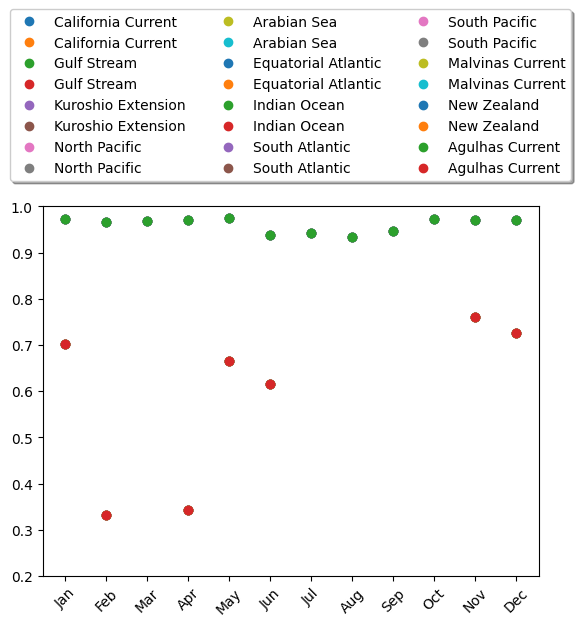

In [19]:
for ii in range(12):
    i_loc = lat_ind_sorted[ii]
    plt.plot(np.roll(r2_cnn_monthly_mean[4,0,:],-3),'o',label=label_list[i_loc])
    plt.plot(np.roll(r2_param_monthly_mean[4,0,:],-3),'o',label=label_list[i_loc])
    

plt.ylim([0.2,1])
my_xticks = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep', 'Oct','Nov','Dec',]
plt.xticks(np.arange(0,12,1), my_xticks,rotation = 45); 
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

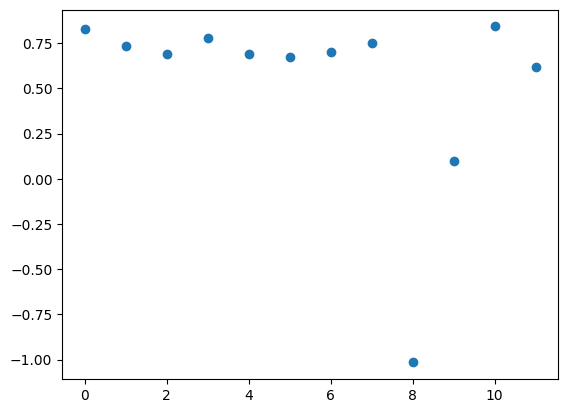

In [22]:
 plt.plot(np.roll(r2_param_monthly_mean[4,:,0],-3),'o',label=label_list[i_loc])